# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 1D problem

### Manufactured solution


We use $u = sin(2*x)$ for $x\in [0,4]$ to manufacture the right hand side to be $f=sin(x)$

### Importing packages

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [120]:
np.random.seed(123)
X_tr_pde = np.random.uniform(0,2*np.pi,2000).reshape(2000,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

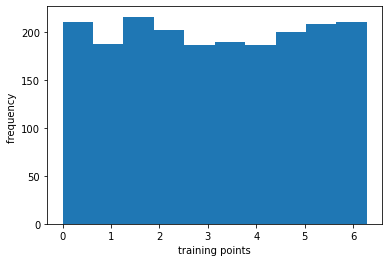

In [121]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

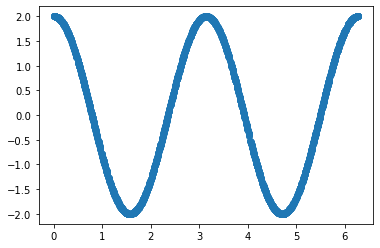

In [122]:
Y_tr_pde = 2*np.cos(2*X_tr_pde)
plt.scatter(X_tr_pde,Y_tr_pde)

In [123]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((X_tr_pde.size,1))],axis=1)
Y_tr_pde.shape

(2000, 2)

In [124]:
X_tr_Dr_bc_left = np.zeros(200).reshape(200,1)
X_tr_Dr_bc_right = 2*np.pi*np.ones(200).reshape(200,1)
X_bc = np.concatenate([X_tr_Dr_bc_left,X_tr_Dr_bc_right],axis=0)

Y_tr_Dr_bc_left = np.sin(X_tr_Dr_bc_left)
Y_tr_Dr_bc_right = np.sin(X_tr_Dr_bc_right)
Y_tr_bc = np.concatenate([Y_tr_Dr_bc_left,Y_tr_Dr_bc_right],axis=0)
Y_tr_bc = np.concatenate([Y_tr_bc,np.ones((400,1))],axis=1)
Y_tr_bc

array([[ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       ...,
       [-2.4492936e-16,  1.0000000e+00],
       [-2.4492936e-16,  1.0000000e+00],
       [-2.4492936e-16,  1.0000000e+00]])

## Scaling the inputs

In [125]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_pde = scaler.fit_transform(X_tr_pde)

In [126]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_bc), axis=0)

In [127]:
Y_tr

array([[-1.56429919e+00,  0.00000000e+00],
       [-1.79727702e+00,  0.00000000e+00],
       [-1.91597615e+00,  0.00000000e+00],
       ...,
       [-2.44929360e-16,  1.00000000e+00],
       [-2.44929360e-16,  1.00000000e+00],
       [-2.44929360e-16,  1.00000000e+00]])

## Training the model

In [128]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.batch_norm_ = keras.layers.BatchNormalization()
        he_kernel_init = keras.initializers.he_uniform()
        self.dense_1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer=he_kernel_init,
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer=he_kernel_init,
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(1,
                                         name="dense_3")

    def findGrad(self,func,argm):
        return keras.layers.Lambda(lambda x: K.gradients(x[0],x[1])) ([func,argm])
    
    def call(self, inputs):
#         layer_0 = self.batch_norm_(inputs)
        layer_1 = self.dense_1(inputs)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        
        grad_layer = self.findGrad(layer_3, inputs)
        laplace_layer = self.findGrad(grad_layer, inputs)
        
        return layer_3, grad_layer



In [129]:
custom_model = CustomModel()

In [130]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

In [131]:
custom_model.compile(loss=[u_loss,pde_loss],optimizer="nadam")

In [132]:
custom_model.fit(x=X_tr, y=Y_tr,epochs=50)

Epoch 1/50
188/188 [==============================] - 1s 4ms/step - loss: 0.2931 - output_1_loss: 0.0213 - output_2_1_loss: 0.2718
Epoch 2/50
188/188 [==============================] - 1s 4ms/step - loss: 0.2289 - output_1_loss: 6.2569e-04 - output_2_1_loss: 0.2282
Epoch 3/50
188/188 [==============================] - 1s 4ms/step - loss: 0.1876 - output_1_loss: 5.2796e-04 - output_2_1_loss: 0.1871
Epoch 4/50
188/188 [==============================] - 1s 3ms/step - loss: 0.1150 - output_1_loss: 7.5435e-04 - output_2_1_loss: 0.1143
Epoch 5/50
188/188 [==============================] - 1s 3ms/step - loss: 0.0385 - output_1_loss: 3.5095e-04 - output_2_1_loss: 0.0381
Epoch 6/50
188/188 [==============================] - 1s 4ms/step - loss: 0.0107 - output_1_loss: 0.0015 - output_2_1_loss: 0.0092
Epoch 7/50
188/188 [==============================] - 1s 5ms/step - loss: 0.0048 - output_1_loss: 0.0017 - output_2_1_loss: 0.0031
Epoch 8/50
188/188 [==============================] - 1s 6ms/step -

In [133]:
custom_model.compile(loss=[u_loss,pde_loss],optimizer=keras.optimizers.SGD(lr=1e-4))
custom_model.fit(x=X_tr, y=Y_tr,epochs=5)

Epoch 1/5
188/188 [==============================] - 1s 4ms/step - loss: 2.3551e-04 - output_1_loss: 3.9383e-07 - output_2_1_loss: 2.3511e-04
Epoch 2/5
188/188 [==============================] - 1s 4ms/step - loss: 2.1944e-04 - output_1_loss: 1.4022e-07 - output_2_1_loss: 2.1930e-04
Epoch 3/5
188/188 [==============================] - 1s 3ms/step - loss: 2.1093e-04 - output_1_loss: 1.2163e-07 - output_2_1_loss: 2.1080e-04
Epoch 4/5
188/188 [==============================] - 1s 4ms/step - loss: 2.0599e-04 - output_1_loss: 1.2995e-07 - output_2_1_loss: 2.0586e-04
Epoch 5/5
188/188 [==============================] - 1s 3ms/step - loss: 2.0285e-04 - output_1_loss: 1.5546e-07 - output_2_1_loss: 2.0270e-04


In [134]:
X_test_st = np.random.uniform(0,2*np.pi,500).reshape(500,1)

In [135]:
#Scaling test set
X_test_st_2 = scaler.transform(X_test_st)

In [136]:
Y_test = custom_model.predict(X_test_st_2)

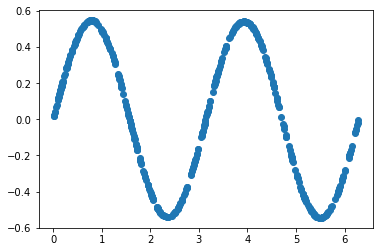

In [137]:
plt.scatter(X_test_st, Y_test[0][:,0])

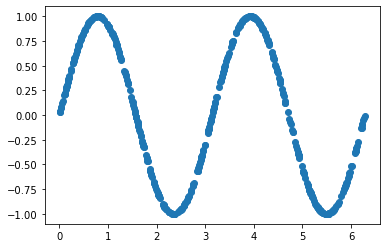

In [138]:
plt.scatter(X_test_st,np.sin(2*X_test_st))

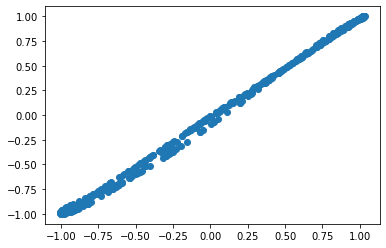

In [117]:
plt.scatter(Y_test[0][:,0],np.sin(2*X_test_st))

### Notes to be made

- For second order pde, the dataset has to be normalized inorder to get convergence.
- Normalization is a problem for 1d problem since, we cant normalize the bc , which are just two endpoints. So the function converges to a another functin of the same shape, but the aplitudes are different.
- Even for the 1d case,  siginificant amount of data was required to make this prediction accurate enough.
- Needed 2000 collocation points inside the domain and 200 data points each on the left and right boundary.

## Things to try next time

1. Try giving more weightage to the loss of the boundary condition, since the number of sampling points is less for bc.
2. Check whether the problem is solved for time dependent problems or problems in 2d since, there will be more information